### QAA-640

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
import math

### Read in Rrs data

In [43]:
Rrs = pd.read_csv('/home/jovyan/Documents/UMCES/culture_IOPs/Phytochop_data/Trios_Rrs.csv', header=0)
Rrs.head()

,Unnamed: 0,350,351,352,353,354,355,356,357,358,...,941,942,943,944,945,946,947,948,949,950
0,6/30/22 10:00,0.004047,0.004024,0.004081,0.004229,0.004238,0.004254,0.004290,0.004399,0.004522,...,0.002303,0.002849,0.002787,0.002654,0.002514,0.002438,0.002305,0.002148,0.002360,0.002642
1,6/30/22 10:15,0.003783,0.003763,0.003820,0.003964,0.003973,0.003990,0.004024,0.004135,0.004260,...,0.002649,0.002802,0.003056,0.003416,0.003776,0.003579,0.003073,0.002479,0.002425,0.002604
2,6/30/22 10:30,0.003196,0.003170,0.003223,0.003362,0.003381,0.003406,0.003442,0.003545,0.003659,...,0.000866,0.000410,0.000423,0.000678,0.000941,0.001084,0.001192,0.001290,0.001489,0.001701
3,6/30/22 10:45,0.003252,0.003225,0.003279,0.003416,0.003437,0.003462,0.003498,0.003605,0.003725,...,0.001525,0.001846,0.001781,0.001627,0.001472,0.001449,0.001449,0.001449,0.001731,0.002077
4,6/30/22 11:00,0.003229,0.003220,0.003287,0.003432,0.003453,0.003480,0.003521,0.003633,0.003758,...,0.001897,0.001866,0.001849,0.001904,0.001950,0.001587,0.001280,0.001019,0.001065,0.001150


### Filter Rrs to 370-900nm

In [44]:
Rrs = Rrs.loc[:,'370':'900']
Rrs.head()
print(Rrs.shape)

(21, 531)


### Calculate median Rrs 

In [45]:
Rrs_med = Rrs.median(axis=0)
Rrs_med

370    0.003070
371    0.003128
372    0.003160
373    0.003173
374    0.003233
         ...   
896    0.000865
897    0.000887
898    0.000893
899    0.000867
900    0.000849
Length: 531, dtype: float64

In [46]:
Rrs_med.to_csv('/home/jovyan/Documents/UMCES/culture_IOPs/Phytochop_data/Trios_Rrs_med.csv', header=False)

### Declare wavelengths

In [8]:
wv = Rrs.columns
wv = np.array([eval(i) for i in wv])
print(wv.size)
print(type(wv))

531
<class 'numpy.ndarray'>


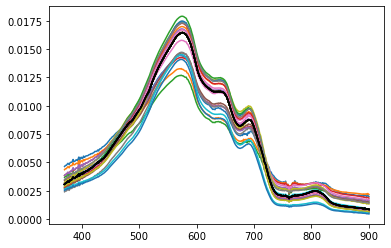

In [9]:
for i in range(len(Rrs)):
    plt.plot(wv, Rrs.iloc[i,:])
    plt.plot(wv, Rrs_med, color='black')


### Step 0. Rrs -> rrs

370    0.005844
371    0.005954
372    0.006015
373    0.006039
374    0.006152
         ...   
896    0.001659
897    0.001701
898    0.001713
899    0.001662
900    0.001628
Length: 531, dtype: float64


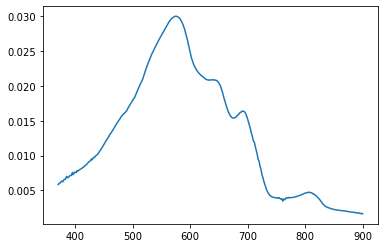

In [10]:
rrs = Rrs_med/(0.52 + 1.7*Rrs_med)
print(rrs)
plt.plot(wv, rrs)

### Step 1. Derivation of u

In [11]:
g0 = 0.0895
g1 = 0.1247

u = (-g0 + (g0**2 + 4*g1*rrs)**(1/2))/(2*g1)
print(u.size)

531


### Step 2. Estimate a(640)

In [12]:
def water_iops_PF_TScorr(wave,T,S):
    # function to obtain seawater absorption and backscattering spectra
    # pure water absorption from Pope and Frye
    # pure water backscattering from Morel
    # corrected for in situ temperature and salinity conditions

    # TODO ask collin this is greater than 730 because 
    #if min(wave)<380 or max(wave)>730:
    if min(wave<380) or max(wave)>900:
        raise ValueError('input wavelengths  are beyond acceptable range')
    else:
        #Pope and Frye pure water absorption 380-730 nm, then Smith and Baker 730-800 nm
        wl_water =np.array([380,382.5,385,387.5,390,392.5,395,397.5,400,402.5,405,407.5,410,412.5,415,417.5,420,422.5,425,427.5,430,432.5,435,437.5,440,442.5,445,447.5,450,452.5,455,457.5,460,462.5,465,467.5,470,472.5,475,477.5,480,482.5,485,487.5,490,492.5,495,497.5,500,502.5,505,507.5,510,512.5,515,517.5,520,522.5,525,527.5,530,532.5,535,537.5,540,542.5,545,547.5,550,552.5,555,557.5,560,562.5,565,567.5,570,572.5,575,577.5,580,582.5,585,587.5,590,592.5,595,597.5,600,602.5,605,607.5,610,612.5,615,617.5,620,622.5,625,627.5,630,632.5,635,637.5,640,642.5,645,647.5,650,652.5,655,657.5,660,662.5,665,667.5,670,672.5,675,677.5,680,682.5,685,687.5,690,692.5,695,697.5,700,702.5,705,707.5,710,712.5,715,717.5,720,722.5,725,727.5,730,732.5,735.0,737.5,740.0,742.5,745.0,747.5,750.0,752.5,755.0,757.5,760.0,762.5,765.0,767.5,770.0,772.5,775.0,777.5,780.0,782.5,785.0,787.5,790.0,792.5,795.0,797.5,800.0])
        a_water  =np.array([0.01137,0.010044,0.00941,0.00917,0.00851,0.00829,0.00813,0.00775,0.00663,0.00579,0.0053,0.00503,0.00473,0.00452,0.00444,0.00442,0.00454,0.00474,0.00478,0.00482,0.00495,0.00504,0.0053,0.0058,0.00635,0.00696,0.00751,0.0083,0.00922,0.00969,0.00962,0.00957,0.00979,0.01005,0.01011,0.0102,0.0106,0.0109,0.0114,0.0121,0.0127,0.0131,0.0136,0.0144,0.015,0.0162,0.0173,0.0191,0.0204,0.0228,0.0256,0.028,0.0325,0.0372,0.0396,0.0399,0.0409,0.0416,0.0417,0.0428,0.0434,0.0447,0.0452,0.0466,0.0474,0.0489,0.0511,0.0537,0.0565,0.0593,0.0596,0.0606,0.0619,0.064,0.0642,0.0672,0.0695,0.0733,0.0772,0.0836,0.0896,0.0989,0.11,0.122,0.1351,0.1516,0.1672,0.1925,0.2224,0.247,0.2577,0.2629,0.2644,0.2665,0.2678,0.2707,0.2755,0.281,0.2834,0.2904,0.2916,0.2995,0.3012,0.3077,0.3108,0.322,0.325,0.335,0.34,0.358,0.371,0.393,0.41,0.424,0.429,0.436,0.439,0.448,0.448,0.461,0.465,0.478,0.486,0.502,0.516,0.538,0.559,0.592,0.624,0.663,0.704,0.756,0.827,0.914,1.007,1.119,1.231,1.356,1.489,1.678,1.7845,1.9333,2.0822,2.2311,2.3800,2.4025,2.4250,2.4475,2.4700,2.4900,2.5100,2.5300,2.5500,2.5400,2.5300,2.5200,2.5100,2.4725,2.4350,2.3975,2.3600,2.3100,2.2600,2.2100,2.1600,2.1375,2.1150,2.0925,2.0700])
        fx       = InterpolatedUnivariateSpline(wl_water,a_water, k=1) # a linear spline interpolator
        a_pw     = fx(wave)

        #Morel water backscattering
        #wl_b=[380  390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 750];
        #b_water=[0.0073    0.0066  0.0058  0.0052  0.0047  0.0043  0.0039  0.0035  0.0032  0.0029  0.0027  0.0024  0.0022  0.002   0.0018  0.0017  0.0016  0.0015  0.0013  0.0013  0.0012  0.0011  0.00101 0.00094 0.00088 0.00082 0.00076 0.00071 0.00067 0.00063 0.00059 0.00055 0.00052 0.0005];
        #%choose pure water scattering function (divide by two for back-scattering):
        #bb_pw=0.5*interp1(wl_b,b_water,wl,'linear');

        #log fit water backscattering
        bb_logfit=.0037000*(380**4.3)/(wave**4.3);

        #salinity correct:
        if S>0:
            bb_sw=((1+0.01*S)*bb_logfit)
        else:
            bb_sw=bb_logfit

        #temp and salinity correction for water absorption (need to know at what T it was measured): 
        if S==0:
            S=35
        if T==0:
            T=22
        T_pope=22.0

        #parameters for temp and salinity callibration (From Pegau et al Applied optics 1997):
        M=np.array([.18, .17, .52, 1.4, 4.6, 2.1, 4.3, 9.6, 1.6, 34, 18, 42])
        sig=np.array([18, 15, 14, 20, 17.5, 15, 17, 22, 6, 18, 20, 25])
        lamda_c=np.array([453, 485, 517, 558, 610, 638, 661, 697, 740, 744, 775, 795])
        M_T=np.array([0.0045,0.002,0.0045,0.002,0.0045,-0.004,0.002,-0.001,0.0045,0.0062,-0.001,-0.001])

        #computing the correction per degree C
#         phi_T = []
#         for i in range(len(wave)):
#             phi_T.append(M_T*M/sig*np.exp(-(wave[i]-lamda_c)**2/2/sig**2))
#         phi_T = np.array(phi_T)

        phi_T = []
        for i in range(len(wave)):
            sum_list = []
            for j in range(len(M)):
                sum_list.append(M_T[j]*M[j]/sig[j]*math.exp(-(wave[i]-lamda_c[j])**2/2/sig[j]**2))
            phi_T.append(sum(sum_list))
        phi_T = np.array(phi_T)
        
        #salinity correction based on Pegau and Zaneveld 1997:
        wls=np.array([412, 440, 488, 510, 532, 555, 650, 676, 715, 750])
        phi_S_PZ=np.array([0.00012,-0.00002,-0.00002,-0.00002,-0.00003,-0.00003,0,-0.00002,-0.00027,0.00064])

        #interpolate to compute salinity correction per psu
        # TODO ask Collin this is actually beyond the limits
        fx = InterpolatedUnivariateSpline(wls,phi_S_PZ, k=1) # a linear spline interpolator
        phi_S   = fx(wave)

        #temperature and salinity corrections:
        a_sw=(a_pw+phi_T.T*(T-T_pope)+phi_S*S)

        return(a_sw, bb_sw)

531
531


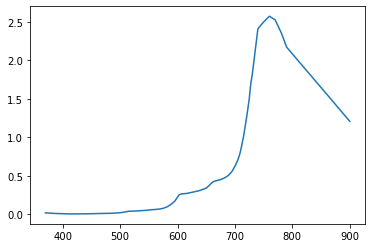

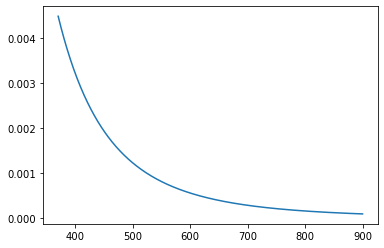

In [13]:
[a_w,bb_w]= water_iops_PF_TScorr(wave=wv,T=24,S=8) # input temperature and salinity

#make into pandas series to include wv
a_w = pd.Series(a_w, wv)
a_w.index = a_w.index.map(str) #change index from int to an object
print(a_w.size)
bb_w = pd.Series(bb_w, wv)
bb_w.index = bb_w.index.map(str)
print(bb_w.size)

plt.plot(wv, a_w)
plt.figure()
plt.plot(wv, bb_w)

In [14]:
chi = np.log10((rrs.loc['443']+rrs.loc['490'])/(rrs.loc['640']+5*(rrs.loc['667']/rrs.loc['490'])*rrs.loc['667']))
print(chi)        
          

-0.5635359826496491


In [15]:
a_640 = a_w.loc['640'] + 10**(-1.146-(1.366*chi)-(0.469*chi**2))
print(a_640)

0.6090844647377849


### Step 3. Calculate bbp(640)

In [16]:
bbp_640 = u.loc['640']*a_640
print(bbp_640)

0.11285096734538452


### Step 4. Estimate exponent of bbp

In [17]:
eta = 2*(1-1.2*math.exp(-0.9*(rrs.loc['443']/rrs.loc['640'])))
print(eta)

0.48672453742750865


### Step 5. Estimate bbp

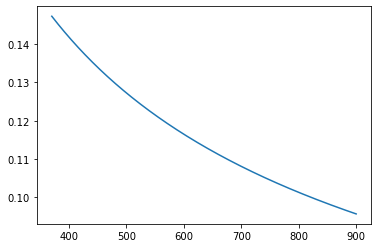

In [18]:
bbp = bbp_640*(640/wv)**eta
plt.plot(wv, bbp)

### Step 6. Estimate a

531


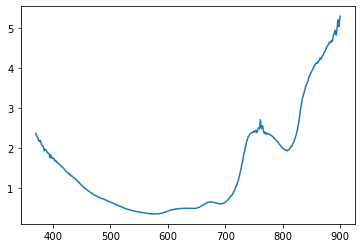

In [19]:
a = ((1-u)*(bb_w + bbp))/u
print(a.size)
plt.plot(wv, a)

### Step 7. Calculate zeta (ratio of phyto abs)

In [20]:
zeta = 0.74 + (0.2/(0.6+(rrs.loc['443']/rrs.loc['640'])))
print(zeta)

0.9197856496080435


### Step 8. Calculate xi (ratio of gelbstoff abs)

In [21]:
#spectral slope:
S = 0.015 + (0.002/(0.6 + (rrs.loc['443']/rrs.loc['640'])))
print(S)

0.016797856496080434


In [22]:
xi = math.e**(S*(443-411))
print(xi)

1.711775965485401


### Step 9. Calcualte adg(443)

In [23]:
adg_443 = ((a.loc['411'] - zeta * a.loc['443']) - (a_w.loc['411'] - zeta * a_w.loc['443']))/(xi - zeta)
print(adg_443)

0.6606871456723709


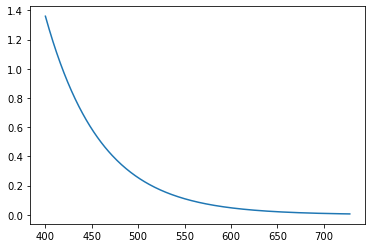

In [24]:
ag = adg_443 * np.exp(-S*(wv[30:359]-443))             
#ag
plt.plot(wv[30:359], ag)

### Step 10. Calculate aph

531


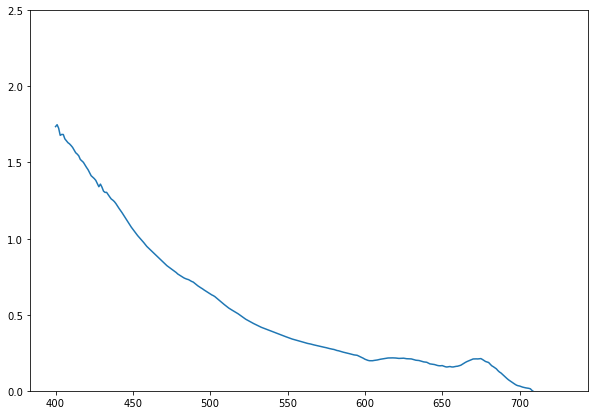

In [25]:
aph = a - a_w - (adg_443*math.e**(-S*wv-443))
print(aph.size)

fig, ax = plt.subplots(figsize=(10,7))
ax.set_ylim(0,2.5)
plt.plot(wv[30:359], aph.loc['400':'728'])

In [113]:
aph = pd.DataFrame(aph,columns=['ap'])
aph.index.name = 'wv'
aph

,ap
wv,
370,3.202945
371,3.141799
372,3.107125
373,3.092283
374,3.033201
...,...
896,7.203930
897,7.005944
898,6.951661


### Read in acs ap

In [26]:
acs_ap = pd.read_csv('/home/jovyan/Documents/UMCES/culture_IOPs/Phytochop_data/acs_ap.csv')
acs_ap


,wv,ap
0,399.1,1.372581
1,402.1,1.392407
2,406.4,1.389193
3,409.6,1.388079
4,413.0,1.388794
...,...,...
75,712.9,0.021132
76,716.8,0.012238
77,720.8,0.005294
78,724.8,0.001738


In [88]:
acs_ap_noscattcorr = pd.read_csv('/home/jovyan/Documents/UMCES/culture_IOPs/Phytochop_data/acs_ap_noscattcorr.csv')


### Plot QAA ap and acs ap

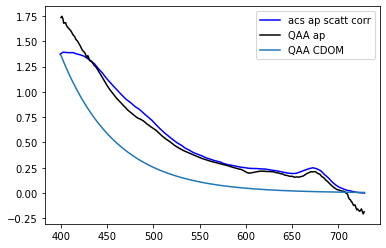

In [27]:
plt.plot(acs_ap.wv, acs_ap.ap, color='blue', label='acs ap scatt corr')
#plt.plot(acs_ap_noscattcorr.wv, acs_ap_noscattcorr.ap, color='green', label='acs ap no scatt corr')
plt.plot(wv[30:359], aph.loc['400':'728'], color='black', label='QAA ap')
plt.plot(wv[30:359], ag, label='QAA CDOM')
plt.legend()


In [98]:
print(acs_ap_noscattcorr.ap.shape)
print(aph.shape)

(80,)
(531,)


In [116]:
aph.wv

AttributeError: 'DataFrame' object has no attribute 'wv'

In [117]:
# find rows with closest wavelengths to acs wavelengths
foo=[]

for i in range(len(aph.index)):
    closest_row = acs_ap_noscattcorr.iloc[(acs_ap_noscattcorr['wv'] - aph.index[i]).abs().argsort()[:1]]
    #print(closest_row)
    foo.append(closest_row)

foo = pd.concat(foo)
print(foo.head())

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

ValueError: x and y must have same first dimension, but have shapes (80, 2) and (531,)

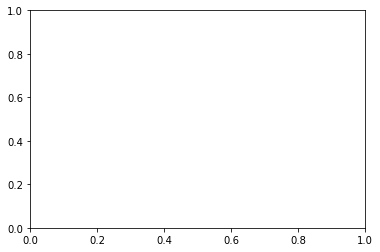

In [99]:
plt.plot(acs_ap_noscattcorr, aph)